## Compute and store binned mean and standard deviation of velocity, sea level, temperature and salinity in Lagrangian perspective

In this notebook, basics statistics are computed using simulated drifters in the LLC4320 simulation. A dataset of this stats is stored.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4904125.datarmor0/parcels-502090/libparcels_random_ef16adda-2c92-4edb-bd05-142ea28891bb.so


In [2]:
from dask.distributed import Client, LocalCluster

if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5)
else:    
    cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.219:52412 Dashboard: http://10.148.0.219:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### load data

In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


#### Manipulation of dataframe : Definition of temporal and spatial bins, spatial units conversion

In [4]:
# Dates of start and end of simulation
t_start = df.index.min().compute()
t_end = df.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


In [5]:
# Convert degrees per second into meter per s
df = pa.degs2ms(df)


In [6]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [7]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [8]:
# Add velocity amplitude in dataframe
df['velocity_amplitude'] = np.sqrt(df.zonal_velocity**2+df.meridional_velocity**2)

In [9]:
df = df.persist()

### Computation and visualization

#### Method 1 : compute mean and std in one line
This method is not finished yet. It is working but 3 jobs are needed to be used in the cluster while only to are enough for method 2.

In [27]:
def mean_std_func(df,V):
    mean_std = df.groupby([df.lon_cut, df.lat_cut])[V].agg(['mean','std']).rename(columns={'mean':V+'_mean','std':V+'_std'}).compute()
    mean_std = pa.add_geodata(mean_std)
    ds_stats = (mean_std
                .drop(columns=['Coordinates'])
                .set_index(['lon', 'lat'])
                .to_xarray()
                )
    return ds_stats#.agg(['mean'],axis='columns')

In [29]:
columns = ['zonal_velocity','meridional_velocity','sea_level','temperature','salinity','velocity_amplitude']

In [30]:
ds_stats = mean_std_func(df,columns[0])
for V in columns[1:]:
    ds_stats_bis = mean_std_func(df,V)
    ds_stats = xr.merge([ds_stats,ds_stats_bis])

#### Visualization : global maps

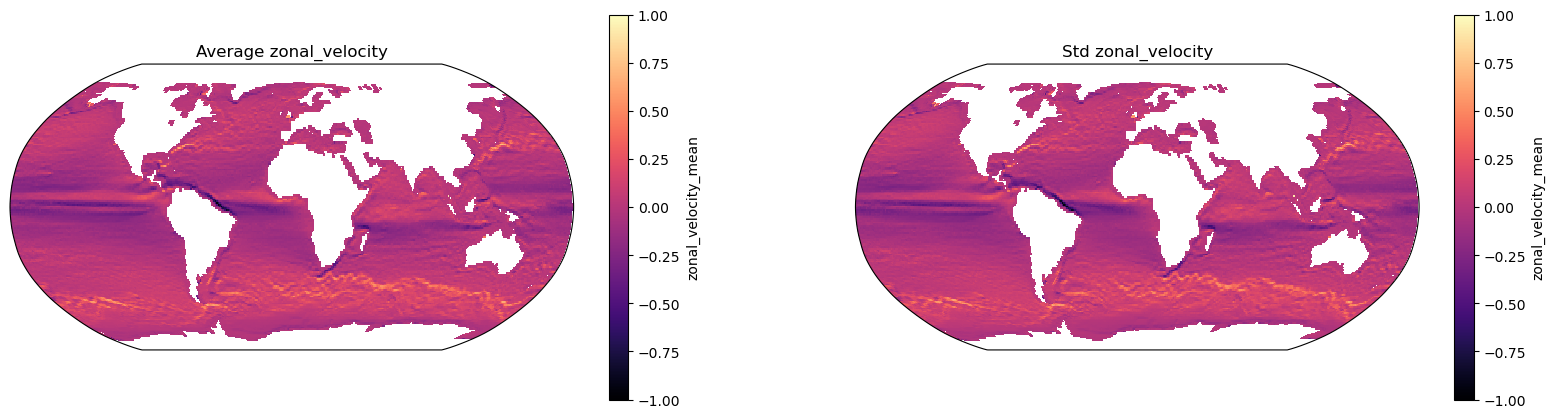

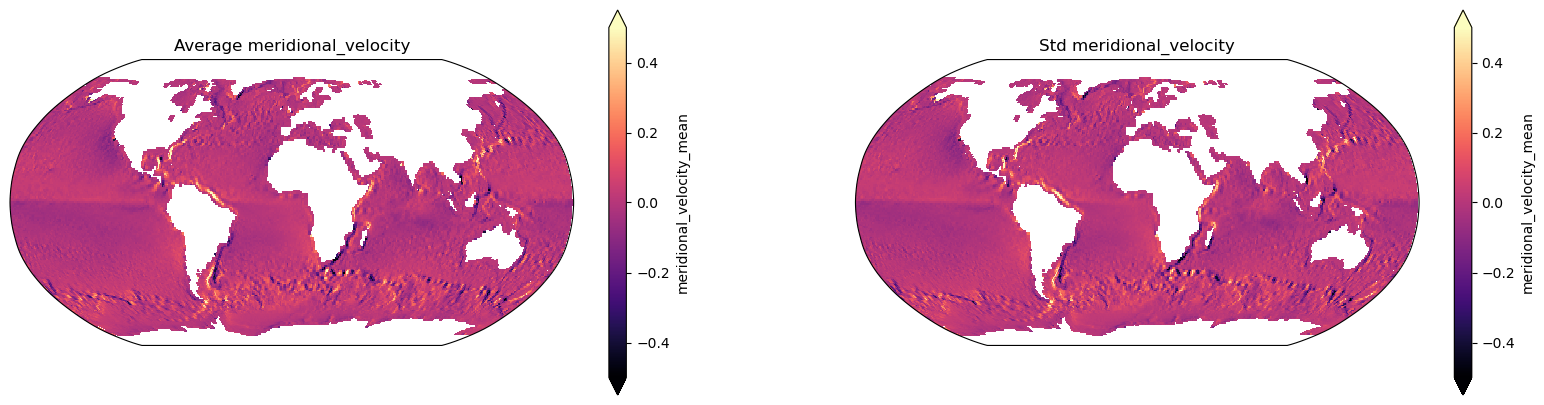

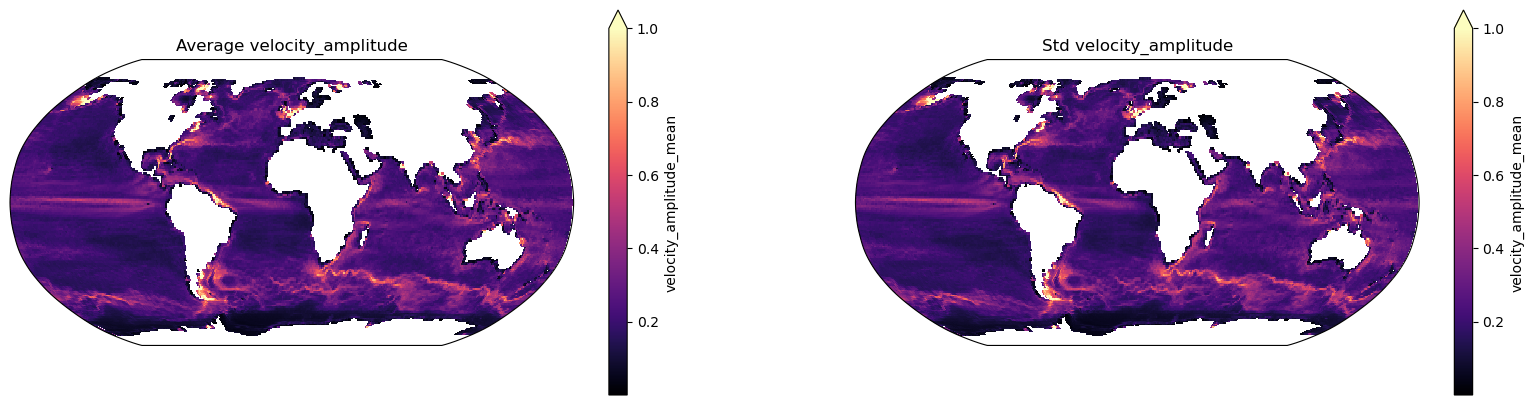

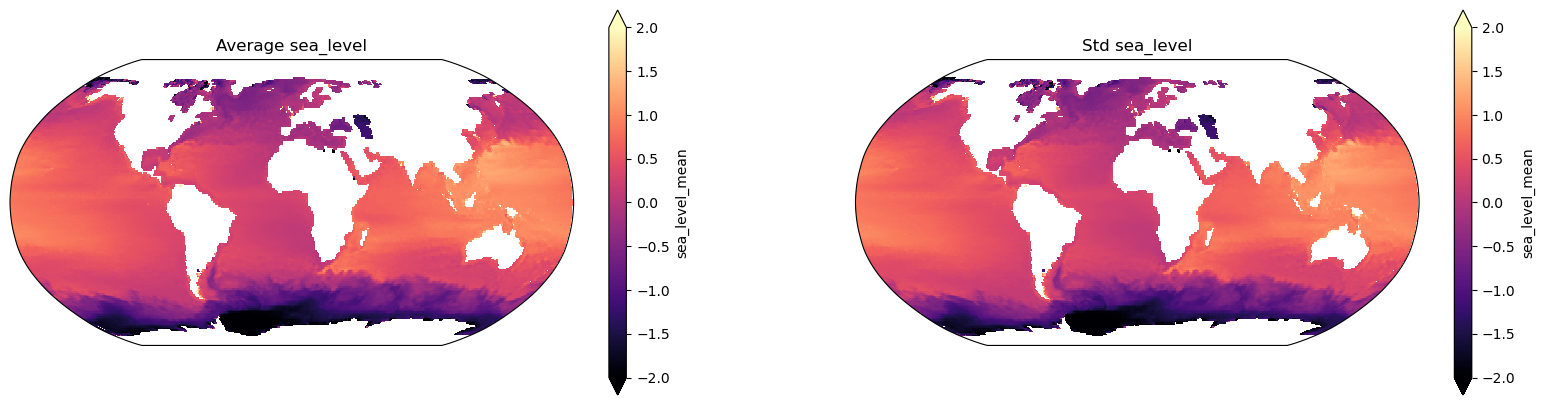

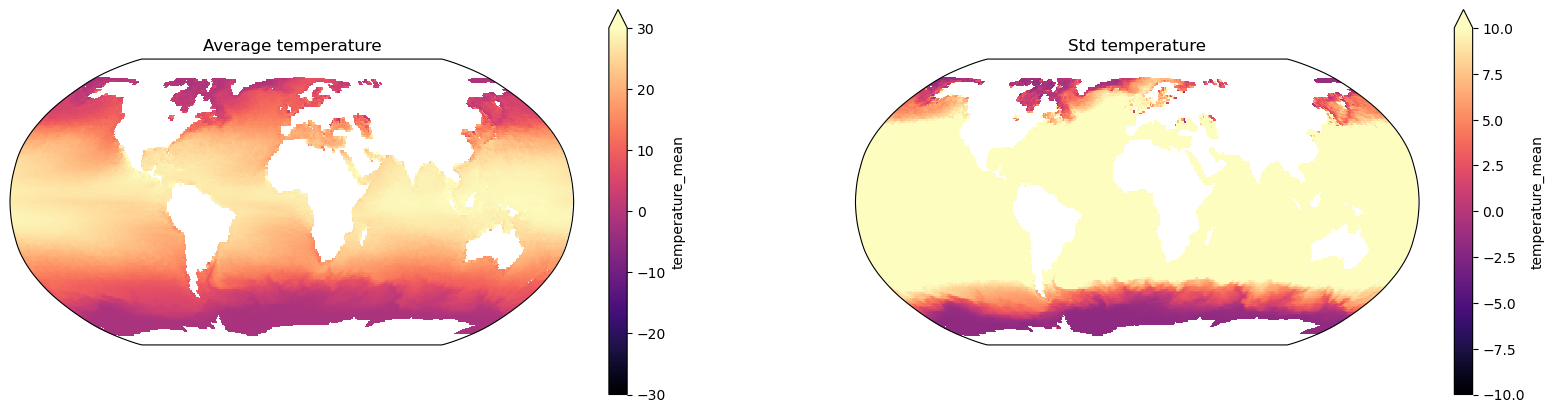

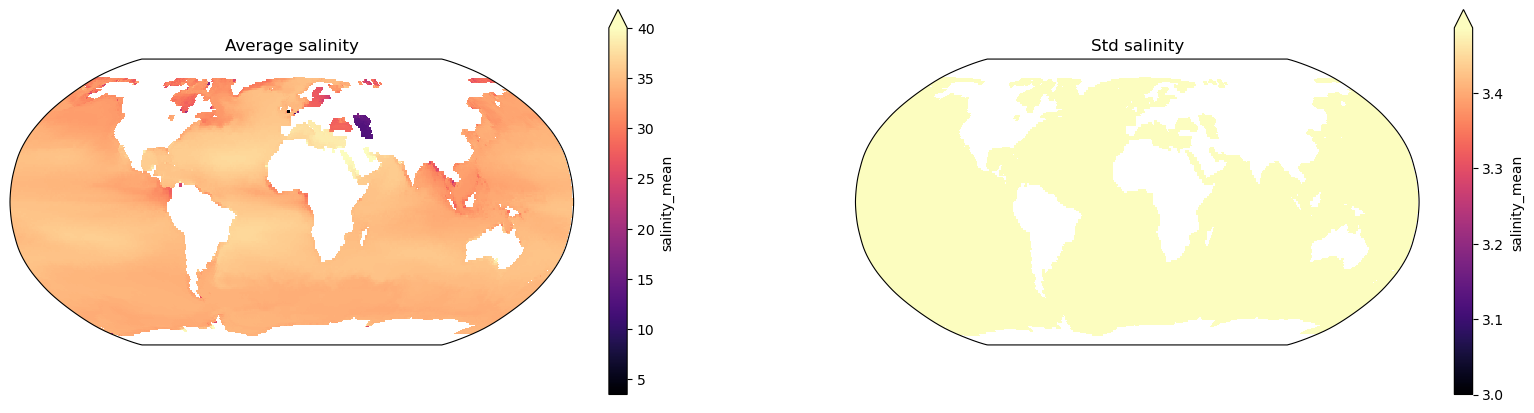

In [32]:
for V,vmax in zip(['zonal_velocity', 'meridional_velocity','velocity_amplitude','sea_level','temperature','salinity'],[[1,1],[0.5,0.5],[1,1],[2,2],[30,10],[40,3]]):
    figsize = (20,5)

    #crs = ccrs.Mollweide()
    crs = ccrs.Robinson()
    #crs = ccrs.EqualEarth()
    #crs = ccrs.Geodetic()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection=crs)

    ds_stats[V+'_mean'].plot(x='lon', 
                     y='lat',
                     vmax=vmax[0],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Average '+V)
    ax = fig.add_subplot(122, projection=crs)

    ds_stats[V+'_mean'].plot(x='lon', 
                     y='lat',
                     vmax=vmax[1],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Std '+V)
    #ax.add_feature(cfeature.LAND, zorder=1)

### Store binned statistics

In [33]:
ds_stats.attrs.update(**{'run_name': run_name,'dl': dl})

In [34]:
#store dataset in diagnostics directory
p.store_diagnostic("L_dl"+str(dl)+"_mean_std", ds_stats,overwrite=True)

L_dl1.0_mean_std diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/L_dl1.0_mean_std.zarr


### Load binned stats : 

In [3]:
# Lagrangian data
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])

df_bin = p.load_diagnostic('L_dl1.0_mean_std.zarr')

In [18]:
cluster.close()